# Pre requisites

# Hongyan's output file or if not available Athena table from Anupam
# QuickSight access to the S3 bucket

# Dependencies

1. NLTK (If not accessible in environment during service, I can remove this)
2. Keras saved tokenizer
2. Keras saved model 

In [1]:
!pip uninstall -y tensorflow-serving-api
!pip install numpy==1.19.2
!pip install awswrangler
!pip install wordcloud
!pip install pyathena
!pip install tensorflow-cpu==2.6.1

  Using cached numpy-1.19.2-cp36-cp36m-manylinux2010_x86_64.whl (14.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awswrangler 2.14.0 requires numpy<1.19.0,>=1.18.0; python_full_version ~= "3.6.2", but you have numpy 1.19.2 which is incompatible.
  Using cached numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.1 requires numpy~=1.19.2, but you have numpy 1.18.5 whic

In [2]:
import os

In [3]:
current_path = os.getcwd()
os.makedirs(f'{current_path}/random_forest_model_files', exist_ok = True)
os.makedirs(f'{current_path}/keras_model_files', exist_ok = True)

# Import Headers

In [4]:
# Pandas, SKLEARN headers
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
tqdm.pandas()
pd.set_option('max_colwidth',0)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pretty_confusion_matrix import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import joblib
import pickle
import io
import os
import json

#NLTK headers
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import awswrangler as wr

# Keras headers
import tensorflow as tf
from tensorflow.keras.models import save_model

#from keras.models import save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
#from pandas_profiling import ProfileReport

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from pyathena import connect
import pandas as pd

conn = connect(s3_staging_dir="s3://aws-athena-query-results-us-west-2-995383923238/ ",
               region_name="us-west-2")
df = pd.read_sql_query(""" SELECT * FROM "ml-workshop-db"."enriched_data" """, conn)
print(df.head())

      id dp_unique_key    target  \
0  12966  uq_id_10256   Neutral    
1  2583   uq_id_1036    Positive   
2  12987  uq_id_10381   Positive   
3  12991  uq_id_10406   Negative   
4  12993  uq_id_10418   Negative   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0  Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Ital

# Load DataSet and rename columns

In [6]:
#url = "https://raw.githubusercontent.com/Cameron-Watts/PDS_Piece/main/data/raw/twitter_training.csv"
#df = pd.read_csv(url, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])


#df = wr.athena.read_sql_query(sql="SELECT * FROM enriched_data", database="ml-workshop-db")

# rename columns
df.columns = ['tweet_id', 'dp_unique_key', 'sentiment', 'tweet_text', 'updated_date', 'entity']

#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

#Convert the "Sentiment" column into indexes
df["sentiment_index"] = names_to_ids(df["sentiment"])

# Twitter Sentiment Analysis Dataset - Overview
# This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

# Look at dataset

In [7]:
df.tail(5)

,tweet_id,dp_unique_key,sentiment,tweet_text,updated_date,entity,sentiment_index
77363,2573,uq_id_976,Negative,This cricket has been dubbed the worst single hivemind of game fandom I have certainly done this more times more than I or would love to be better if the Tarzan level in Kingdom Hearts is as bad there as Borderlands.,21-03-2022,Borderlands,2
77364,12897,uq_id_9854,Positive,Welp. Ruthless Sony can best explain why I made my choice.,21-03-2022,Xbox(Xseries),3
77365,12909,uq_id_9929,Positive,The news there keeps getting better and better. VERY really looking forward to picking up my Series III from day one (and playing Dark Infinite with @runslikedeb immediately),21-03-2022,Xbox(Xseries),3
77366,12914,uq_id_9956,Positive,Very interesting.......,21-03-2022,Xbox(Xseries),3
77367,12916,uq_id_9971,Positive,A great console for a noble cause,21-03-2022,Xbox(Xseries),3


In [8]:
df.sentiment.value_counts()

Negative      23185
Positive      21739
Neutral       19357
Irrelevant    13087
Name: sentiment, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77368 entries, 0 to 77367
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         77368 non-null  int64 
 1   dp_unique_key    77368 non-null  object
 2   sentiment        77368 non-null  object
 3   tweet_text       77368 non-null  object
 4   updated_date     77368 non-null  object
 5   entity           77368 non-null  object
 6   sentiment_index  77368 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 4.1+ MB


# Filter out rows where tweet_text is NULL

In [10]:
# fiter data where tweet is present
df = df[df.tweet_text.isnull()==False]
df['tweet_text'] = df['tweet_text'].astype(str)

# Stratified Sampling - For this session purposes lets restrict to 5000 records for each class

In [11]:
number_of_rows_each_class = 2000
dfs_list = []
for unique_sentiment in np.unique(df.sentiment):
    df_sentiment = df[df.sentiment == unique_sentiment].sample(n=number_of_rows_each_class, random_state = 42)
    dfs_list.append(df_sentiment)
df = pd.concat(dfs_list)
df = df.sample(frac=1, random_state = 42)
df = df.reset_index(drop = True)

In [12]:
df.sentiment.value_counts()

Neutral       2000
Irrelevant    2000
Negative      2000
Positive      2000
Name: sentiment, dtype: int64

# We might want to look at what is present in the tweets. So a wordcloud can be helpful

In [13]:
import os
from wordcloud import WordCloud
def word_cloud(tweets):
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array    
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                           background_color="black", max_words=2000, 
                           contour_width=1, contour_color="steelblue", 
                           colormap="nipy_spectral").generate(tweets)

    #Now we plot the figure
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show()   


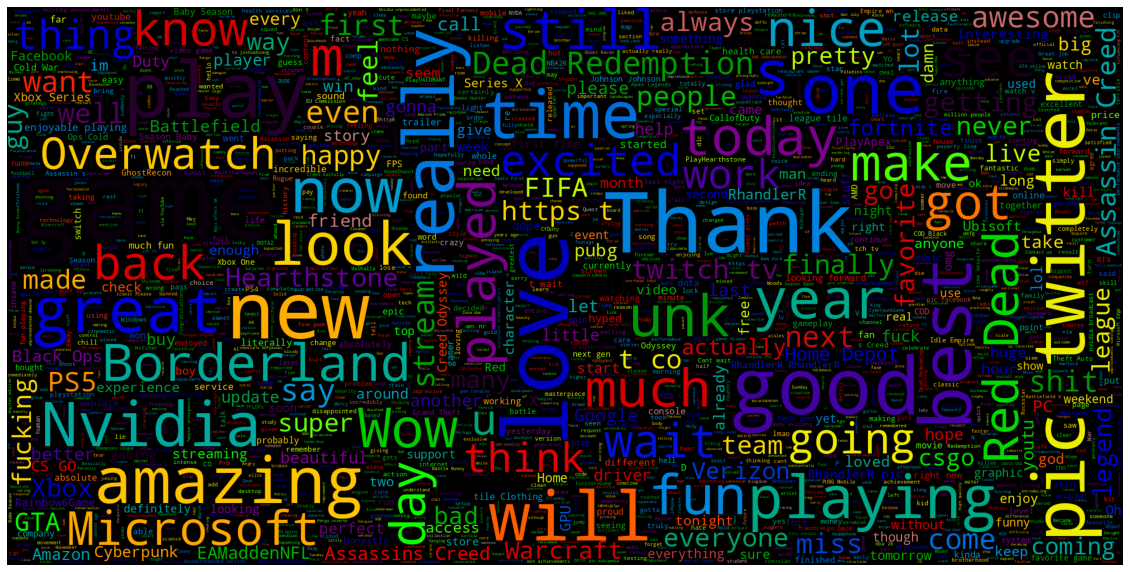

In [14]:
# Positive tweets word cloud
word_cloud((df[df.sentiment=='Positive'].tweet_text).str.cat(sep=' ')) 

# Modelling - Classic BOW model


# Prepare dataset for modelling

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet_text):
    tweet_text = re.sub('[^a-zA-Z]', ' ', tweet_text)
    tweet_text = tweet_text.lower()
    tweet_text = tweet_text.split()
    tweet_text = [lemmatizer.lemmatize(word) for word in tweet_text if (not(word in set(stopwords))) & (len(word)>1) ]
    tweet_text = ' '.join(tweet_text)
    return tweet_text

df['tweet_text_preprocessed'] = df['tweet_text'].progress_apply(preprocess_tweet)
df = df[df.tweet_text_preprocessed.apply(lambda text: len(text.split())>1)]
#df['tweet_tokenized'] = df['tweet_tokenized'].progress_apply(lemmatize)



100%|██████████| 8000/8000 [00:02<00:00, 3401.96it/s]


# Take a look at pre-processed text

In [16]:
df[['tweet_text','tweet_text_preprocessed', 'sentiment']].head(30)

,tweet_text,tweet_text_preprocessed,sentiment
0,PSA:. @ DOTA2 servers lag behind again,psa dota server lag behind,Negative
1,2 FUCK 'EM. Support black businesses . . twitter.com/HoboDia/status…,fuck em support black business twitter com hobodia status,Negative
2,"""\""Live with some . . \""\""why you so toxic\""\"" - random teammate. \""\""I've fucked your mum\""\"" - My long lost 12 year old father. . Twitch.tv/casualcable\""""",live toxic random teammate fucked mum long lost year old father twitch tv casualcable,Irrelevant
4,"Completely stunned and saddened to learn of @iceycat25's passing. Please @Rainbow6Game, let's get a tribute to him in the game. A charm, a gun skin, a piece of artwork... Anything. . . Let's honor this guy who did so much for the community.",completely stunned saddened learn iceycat passing please rainbow game let get tribute game charm gun skin piece artwork anything let honor guy much community,Neutral
5,@ GearboxOfficial @ Borderlands. Do I see this shit right? Please tell me it's not me.... I'm being attacked while the ENDCREDITES are rolling?!. They ended and there were enemies everywhere! WHY IS THIS THING?!.,gearboxofficial borderland see shit right please tell attacked endcredites rolling ended enemy everywhere thing,Negative
6,21 THE AT MASTIFF NO IS BROKEN!. 3 LINK - t youtu. be / t AzuYJNzs7q0.. N @PlayApex.,mastiff broken link youtu azuyjnzs playapex,Irrelevant
7,Good Wednesday morning! Not as chilly today and it will be brighter too for,good wednesday morning chilly today brighter,Irrelevant
8,"Give me a fun @ CallofDuty @ ModernWarzone You have an update and just released season 5 and now you have a 66GB update. I hope it's to disable cross-play because this shit is getting ridiculous. I love the game but to be honest, it's garbage.",give fun callofduty modernwarzone update released season gb update hope disable cross play shit getting ridiculous love game honest garbage,Neutral
9,I’ve had this game for 5 days and I have YET to win a TTO Offline game. That’s ridiculous. Last year I won my first 20 or something in a day. What bs. @NBA2K_MyTEAM,game day yet win tto offline game ridiculous last year first something day b nba myteam,Negative
10,@LAGTVMB the tribute you did for @blue622 in GTA was incredible. Chills. Thanks Jim. He’ll will missed.,lagtvmb tribute blue gta incredible chill thanks jim missed,Irrelevant


# Take a look at the number of rows

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7427 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 7427 non-null   int64 
 1   dp_unique_key            7427 non-null   object
 2   sentiment                7427 non-null   object
 3   tweet_text               7427 non-null   object
 4   updated_date             7427 non-null   object
 5   entity                   7427 non-null   object
 6   sentiment_index          7427 non-null   int64 
 7   tweet_text_preprocessed  7427 non-null   object
dtypes: int64(2), object(6)
memory usage: 522.2+ KB


# Split into train and test

In [18]:
train_df, test_df = train_test_split(df,test_size = 0.05, random_state =42)

train_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

X_train = train_df['tweet_text_preprocessed']
y_train = train_df['sentiment']

X_test = test_df['tweet_text_preprocessed']
y_test = test_df['sentiment']

# Use TF IDF Vectorizer 

In [19]:
# TF-IDF feature matrix
max_number_of_words = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=max_number_of_words, lowercase =True, stop_words='english', token_pattern=r'\w{2,}')
tfidf_vectorizer.fit(X_train)
print('No. of feature_words: ', len(tfidf_vectorizer.get_feature_names()))

No. of feature_words:  1000


In [20]:
X_train = tfidf_vectorizer.transform(X_train)
X_test  = tfidf_vectorizer.transform(X_test)

# Fit Random Forest model

In [21]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# export model
joblib.dump(tfidf_vectorizer, f'{current_path}/random_forest_model_files/tfidf_vectorizer.joblib')
joblib.dump(rf_clf, f'{current_path}/random_forest_model_files/random_forest.joblib')

['/home/ec2-user/SageMaker/ml-workshop/random_forest_model_files/random_forest.joblib']

In [23]:
rf_predictions = rf_clf.predict(X_test)

/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


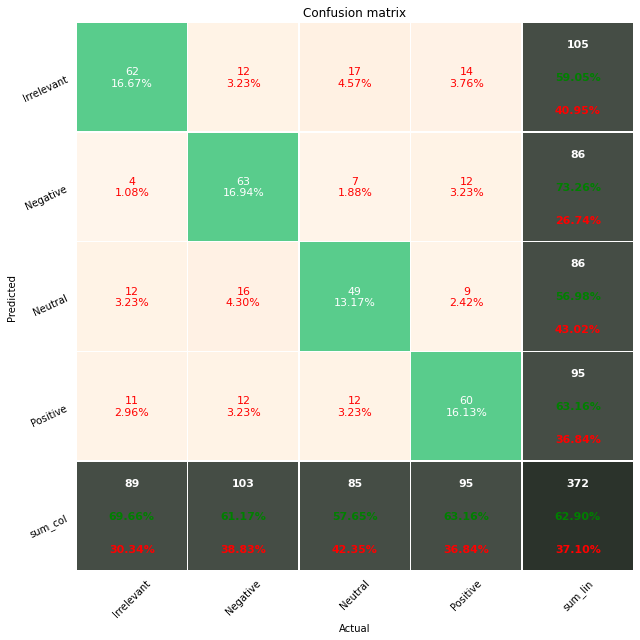

In [24]:
from pretty_confusion_matrix import *
pp_matrix_from_data(y_test, rf_predictions, columns = ['Irrelevant','Negative', 'Neutral', 'Positive'])

In [25]:
# predict
# load
tfidf_vectorizer = joblib.load(f'{current_path}/random_forest_model_files/tfidf_vectorizer.joblib')
rf_clf = joblib.load(f'{current_path}/random_forest_model_files/random_forest.joblib')
negative_tweet_text = 'i had an very sick bad service'
positive_tweet_text = 'i had an excellent service'
def predict(tweet_texts, tfidf_vectorizer):
    processed_texts = []
    for tweet_text in tweet_texts:        
        tweet_text = tweet_text.split()
        tweet_text = [lemmatizer.lemmatize(word) for word in tweet_text if not word in set(stopwords)]
        tweet_text = ' '.join(tweet_text)
        processed_texts.append(tweet_text)
    tweet_texts_tfidf = tfidf_vectorizer.transform(processed_texts)
    predictions = rf_clf.predict(tweet_texts_tfidf)
    return predictions
predict([negative_tweet_text, positive_tweet_text], tfidf_vectorizer)

array(['Negative', 'Negative'], dtype=object)

# Keras tokenization word embedding model

In [26]:
max_words = 5000
max_len=50

keras_tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')


def tokenize_pad_sequences(tweet_text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    tweet_text = tokenizer.texts_to_sequences(tweet_text)
    # Pad sequences to the same length
    tweet_text = pad_sequences(tweet_text, padding='post', maxlen=max_len)
    # return sequences
    return tweet_text

keras_tokenizer.fit_on_texts(train_df['tweet_text_preprocessed'])
train_texts_to_sequences = keras_tokenizer.texts_to_sequences(train_df['tweet_text_preprocessed'])
train_texts_to_sequences = pad_sequences(train_texts_to_sequences, padding='post', maxlen=max_len)

train_df['tweet_keras_tokenized'] = list(train_texts_to_sequences)


test_texts_to_sequences = keras_tokenizer.texts_to_sequences(test_df['tweet_text_preprocessed'])
test_texts_to_sequences = pad_sequences(test_texts_to_sequences, padding='post', maxlen=max_len)

test_df['tweet_keras_tokenized'] = list(test_texts_to_sequences)


# saving
# with open('keras_tokenizer.pickle', 'wb') as handle:
#     pickle.dump(keras_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

tokenizer_json =  keras_tokenizer.to_json()
with io.open(f'{current_path}/keras_model_files/keras_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Keras text based models

In [27]:
keras_model = Sequential()
embedding_vector_size = 16
lstm_units = 20
keras_model.add(Embedding(max_words,embedding_vector_size,input_length=max_len))
#keras_model.add(Bidirectional(LSTM(20, return_sequences=True)))
keras_model.add(Bidirectional(LSTM(lstm_units)))
keras_model.add(Dense(4, activation='softmax'))
keras_model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy'])

In [28]:
X_train_keras = train_texts_to_sequences
y_train_keras = train_df['sentiment_index']

X_test_keras = test_texts_to_sequences
y_test_keras = test_df['sentiment_index']

keras_model.fit(
     X_train_keras, y_train_keras,
     validation_data=(X_test_keras, y_test_keras),
     epochs=1)

221/221 [==============================] - 9s 30ms/step - loss: 1.3406 - accuracy: 0.3510 - val_loss: 1.2468 - val_accuracy: 0.4516


/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/ml-workshop/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


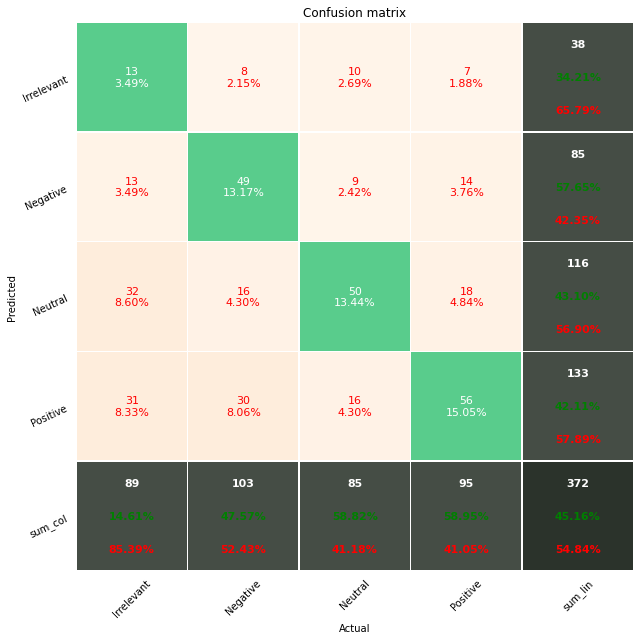

In [29]:
#Generate predictions
keras_predictions = np.argmax(keras_model.predict(test_texts_to_sequences), axis=1)

#Assign labels to predictions and test data
keras_prediction_labels = ids_to_names(keras_predictions)
#y_test_labels = ids_to_names(y_test)

from pretty_confusion_matrix import *
pp_matrix_from_data(test_df['sentiment'], keras_prediction_labels, columns = ['Irrelevant','Negative', 'Neutral', 'Positive'])

In [30]:
save_model(keras_model, f'{current_path}/keras_model_files/', save_format='tf')

INFO:tensorflow:Assets written to: /home/ec2-user/SageMaker/ml-workshop/keras_model_files/assets


INFO:tensorflow:Assets written to: /home/ec2-user/SageMaker/ml-workshop/keras_model_files/assets


In [31]:
test_df.head(2)

,tweet_id,dp_unique_key,sentiment,tweet_text,updated_date,entity,sentiment_index,tweet_text_preprocessed,tweet_keras_tokenized
0,6560,uq_id_33532,Irrelevant,"Back at the OG memes... All I love shining the sky over base, follow me daily every day @Cyper has for everyday content.",21-03-2022,Fortnite,1,back og meme love shining sky base follow daily every day cyper everyday content,"[46, 1109, 1632, 15, 1517, 1280, 435, 421, 82, 30, 811, 335, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,6861,uq_id_65748,Neutral,Johnson & Johnson Will Stop Selling Talc-Based Baby Powder phillyfinest369.com/johnson-johnso…,21-03-2022,johnson&johnson,0,johnson johnson stop selling talc based baby powder phillyfinest com johnson johnso,"[22, 22, 104, 458, 537, 591, 186, 354, 2, 22, 2085, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Combine datasets results and save it to S3

In [32]:
s3_save_path = 's3://datascience-ml-workshop-prep/model_building_component/model-results/'
test_df['rf_output_labels'] = rf_predictions
test_df['keras_output_labels'] = keras_prediction_labels
test_df = test_df.reset_index(drop = True)
wr.s3.to_parquet(
    df=test_df[['tweet_id', 'tweet_text', 'sentiment', 'rf_output_labels', 'keras_output_labels']],
    path='s3://datascience-ml-workshop-prep/model_building_component/model-results/',
    dataset=True
)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


{'paths': ['s3://datascience-ml-workshop-prep/model_building_component/model-results/3db7c700b3164f6e896d632c4e0989a3.snappy.parquet'],
 'partitions_values': {}}

In [34]:
# Predict in Keras
with open(f'{current_path}/keras_model_files/keras_tokenizer.json') as f:
    data = json.load(f)
    keras_tokenizer = tokenizer_from_json(data)

reconstructed_keras_model = load_model(f'{current_path}/keras_model_files/')

preprocessed_tweet = [preprocess_tweet(tweet_text) for tweet_text in [negative_tweet_text, positive_tweet_text]]

predict_texts_to_sequences = keras_tokenizer.texts_to_sequences(preprocessed_tweet)
predict_texts_to_sequences = pad_sequences(predict_texts_to_sequences, padding='post', maxlen=max_len)

keras_predictions = np.argmax(reconstructed_keras_model.predict(predict_texts_to_sequences), axis=1)

keras_prediction_labels_test = ids_to_names(keras_predictions)

# Save dataset to S3. Using Glue, load the dataset in Athena and show a QuickSight dasboard

# TRY IT OUT : Train model on full dataset and see if you see the model accuracy improving